# Multilayer Perceptron for Financial Forecasting

A comprehensive analysis using polynomial detrending, seasonal differencing, and neural networks for time series prediction.

In [369]:
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

excel_file = 'M3C.xls'
sheet_name = "M3Month"
category = "FINANCE"

In [370]:
data = pd.read_excel(excel_file, sheet_name=sheet_name)
print("Loaded {}".format(sheet_name))

Loaded M3Month


In [371]:
# Start from the 7th column (index 6) to the end
category_data = data[data['Category'].str.strip() == category]
series = category_data.iloc[0, 6:].dropna().astype(float)  # Changed from iloc[0] to iloc[1] for second series

2. Here we take the first monthly timeseries in the category of finance. We plot it alongside its 2nd degree polynomial trend.

Selected series length: 143 time points


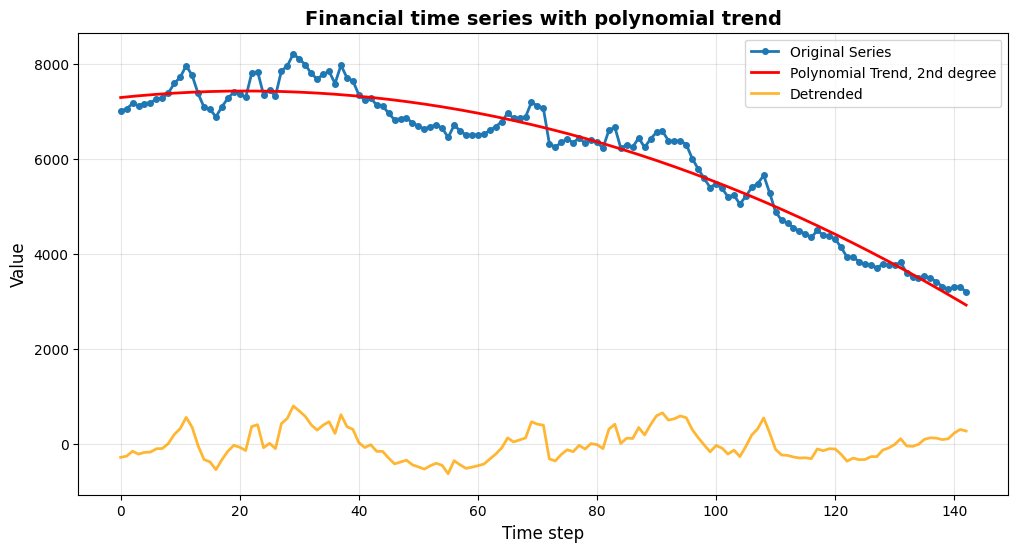

In [372]:
 # One times series with polynomial trend
print(f"Selected series length: {len(series)} time points")
poly = PolynomialFeatures(degree=2)
X = np.arange(len(series)).reshape(-1, 1)
y = series.values

x_poly = poly.fit_transform(X)
poly_model = LinearRegression()
poly_model.fit(x_poly, y)
poly_trend = poly_model.predict(x_poly)
de_trended = y - poly_trend


plt.figure(figsize=(12, 6))
plt.plot(series.values, marker='o', linewidth=2, markersize=4, label='Original Series')
plt.plot(poly_trend, color='red', linewidth=2, label='Polynomial Trend, 2nd degree')
plt.plot(range(len(de_trended)), de_trended, 'orange', linewidth=2, label='Detrended', alpha=0.8)

plt.title("Financial time series with polynomial trend", fontsize=14, fontweight='bold')
plt.legend()
plt.xlabel("Time step", fontsize=12)
plt.ylabel("Value", fontsize=12)
plt.grid(True, alpha=0.3)
plt.show()

3. Next up is de-trending and de-seasonalizing the timeseries to prepare the input for the MLP

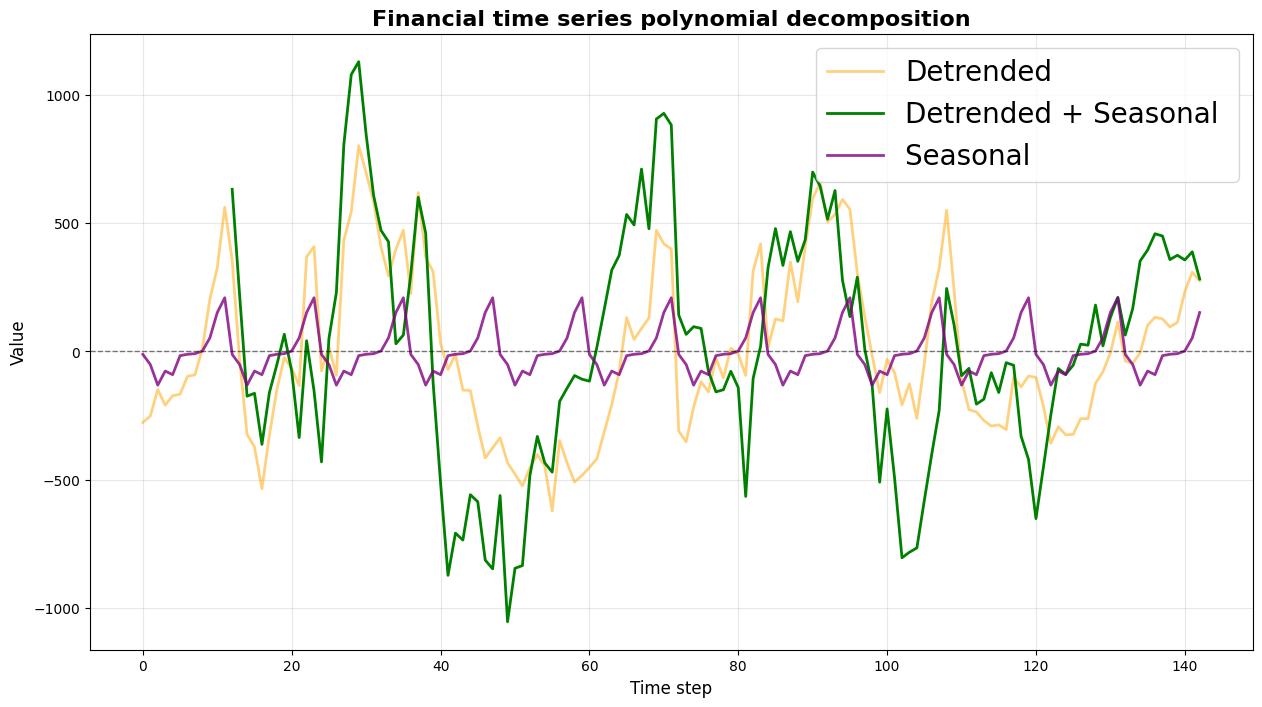

In [373]:

de_trended = y - poly_trend

seasonal_component = np.zeros(len(de_trended))
months_in_year = 12
seasonal_diff = list()

for i in range(months_in_year, len(de_trended)):
    value = de_trended[i] - de_trended[i - months_in_year]
    seasonal_diff.append(value)

# Seasonal component calculation
for m in range(months_in_year):
    month_indices = np.arange(m, len(de_trended), months_in_year)
    month_mean = np.mean(de_trended[month_indices])
    seasonal_component[month_indices] = month_mean



# Combined plot
plt.figure(figsize=(15, 8))
#plt.plot(range(len(y)), y, 'b-', linewidth=2, label='Original', alpha=0.8) # original series
plt.plot(range(len(de_trended)), de_trended, 'orange', linewidth=2, label='Detrended', alpha=0.5) # detrended series
plt.plot(range(months_in_year, len(de_trended)), seasonal_diff, 'green', linewidth=2, label='Detrended + Seasonal ') # detrended + seasonal differenced series
plt.plot(range(len(seasonal_component)), seasonal_component, 'purple', linewidth=2, label='Seasonal ', alpha=0.8) # seasonal component

plt.title("Financial time series polynomial decomposition", fontsize=16, fontweight='bold')
plt.xlabel("Time step", fontsize=12)
plt.ylabel("Value", fontsize=12)
plt.grid(True, alpha=0.3)
plt.axhline(0, color='black', linewidth=1, linestyle='--', alpha=0.5)
plt.legend(fontsize=20)  
plt.show()



In [374]:
print(seasonal_diff_scaled)

[ 1.36699335  0.455511   -0.41425041 -0.38977071 -0.82929862 -0.38341526
 -0.14437067  0.11851445 -0.20004478 -0.77091641  0.06281726 -0.36854305
 -0.98025265  0.08239438  0.47772697  1.75008248  2.35468206  2.4652526
  1.83853228  1.31512099  1.01289695  0.91552498  0.036713    0.11174347
  0.63577084  1.29842655  0.98980088 -0.29959823 -1.16229577 -1.95678287
 -1.59345842 -1.65286212 -1.26260668 -1.32333485 -1.82533381 -1.90129344
 -1.26998363 -2.35629663 -1.89628554 -1.87290957 -1.09877725 -0.76083857
 -0.98845054 -1.06838359 -0.45914836 -0.34526663 -0.23668279 -0.26805178
 -0.28529303  0.00584755  0.33517715  0.67046689  0.79781411  1.15010127
  1.05957242  1.54099585  1.02685588  1.97228691  2.02060715  1.92102773
  0.28439553  0.11793013  0.18391003  0.16909698 -0.20244123 -0.37707421
 -0.35899614 -0.20008228 -0.34049967 -1.27758853 -0.26107736  0.01416953
  0.69139446  1.0286709   0.7116569   1.00213524  0.74670931  0.93233341
  1.51507915  1.39452888  1.10930226  1.35629369  0.

4. The data is scaled before being used as input. We also save the last 12 months of the timeseries to use for validation of our model

In [375]:
# Normalize the seasonal_diff data - FIT ONLY ON TRAINING PORTION to prevent data leakage
from sklearn.preprocessing import StandardScaler

# Split BEFORE scaling
seasonal_diff_array = np.array(seasonal_diff)
train_portion = seasonal_diff_array[:-12]  # All except last 12
validation_portion = seasonal_diff_array[-12:]  # Last 12

# Fit scaler ONLY on training data
scaler = StandardScaler()
scaler.fit(train_portion.reshape(-1, 1))

# Transform both using the same scaler
training_data = scaler.transform(train_portion.reshape(-1, 1)).flatten()
validation_data = scaler.transform(validation_portion.reshape(-1, 1)).flatten()    

# Function to create sequences for the model. Given the last 12 months (x), predict the next month (y)
def create_sequences(data, lookback=12):

    X, y = [], []
    for i in range(len(data) - lookback):
        X.append(data[i:i + lookback])
        y.append(data[i + lookback])
    return np.array(X), np.array(y)

# Sequences only from the training data
X_train, y_train = create_sequences(training_data, lookback=12)

print(f"Training data length: {len(training_data)}")
print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"Training Mean: {training_data.mean():.6f}, Training Std: {training_data.std():.6f}")


Training data length: 119
X_train shape: (107, 12)
y_train shape: (107,)
Training Mean: 0.000000, Training Std: 1.000000


In [376]:
class MLP:
    def __init__(self, input_size, hidden_size, output_size, learning_rate=0.005):
        # Better weight initialization (He initialization for tanh)
        self.weight_hidden = np.random.randn(input_size, hidden_size) * np.sqrt(2.0 / input_size)
        self.weight_output = np.random.randn(hidden_size, output_size) * np.sqrt(2.0 / hidden_size)
        self.bias_hidden = np.zeros((1, hidden_size))
        self.bias_output = np.zeros((1, output_size))
        self.learning_rate = learning_rate
        self.losses = []

    # In our implementation we chose the tanh activation function for the hidden layer
    def tanh(self, x):
        return np.tanh(x)
    
    def tanh_derivative(self, x):
        return 1.0 - np.tanh(x) ** 2

    def forward(self, X):
        # Hidden layer with tanh activation
        self.hidden_input = X @ self.weight_hidden + self.bias_hidden
        self.hidden_output = self.tanh(self.hidden_input)
        
        # No activation for the output, since we are doing regression
        self.final_input = self.hidden_output @ self.weight_output + self.bias_output
        self.final_output = self.final_input  
        
        return self.final_output
    
    def backward(self, X, y, output):
        m = X.shape[0]  # sample size
        
        # reshape to match output shape
        y = y.reshape(-1, 1)
        
        output_error = output - y  
        
        # Hidden layer gradient
        hidden_error = np.dot(output_error, self.weight_output.T) * self.tanh_derivative(self.hidden_input)
        
        # weights and bias update
        self.weight_output -= self.learning_rate * np.dot(self.hidden_output.T, output_error) / m
        self.bias_output -= self.learning_rate * np.sum(output_error, axis=0, keepdims=True) / m
        self.weight_hidden -= self.learning_rate * np.dot(X.T, hidden_error) / m
        self.bias_hidden -= self.learning_rate * np.sum(hidden_error, axis=0, keepdims=True) / m

    def train(self, X, y, epochs, patience=None, min_delta=1e-6):
        """
        Train with optional early stopping
        
        Parameters:
        - patience: Stop if no improvement for this many epochs (None = no early stopping)
        - min_delta: Minimum change to qualify as improvement
        """
        best_loss = float('inf')
        patience_counter = 0
        best_weights = None
        
        for epoch in tqdm(range(epochs), desc="Training progress"):
            # Forward pass
            output = self.forward(X)
            
            # Backward pass
            self.backward(X, y, output)
            
            # MSE
            loss = np.mean((output - y.reshape(-1, 1)) ** 2)
            self.losses.append(loss)
            
            # Early stopping logic (only if patience is set)
            if patience is not None:
                if loss < best_loss - min_delta:
                    best_loss = loss
                    patience_counter = 0
                    # Save best weights
                    best_weights = {
                        'weight_hidden': self.weight_hidden.copy(),
                        'weight_output': self.weight_output.copy(),
                        'bias_hidden': self.bias_hidden.copy(),
                        'bias_output': self.bias_output.copy()
                    }
                else:
                    patience_counter += 1
                
                # Stop if patience exceeded
                if patience_counter >= patience:
                    tqdm.write(f"\n⚠️ Early stopping at epoch {epoch+1}")
                    tqdm.write(f"Best loss: {best_loss:.6f}")
                    # Restore best weights
                    if best_weights:
                        self.weight_hidden = best_weights['weight_hidden']
                        self.weight_output = best_weights['weight_output']
                        self.bias_hidden = best_weights['bias_hidden']
                        self.bias_output = best_weights['bias_output']
                    break
            
            # Progress updates
            if (epoch + 1) % 100000 == 0:
                if patience is not None:
                    tqdm.write(f"Epoch {epoch+1}/{epochs}, Loss: {loss:.6f}, Best: {best_loss:.6f}, Patience: {patience_counter}/{patience}")
                else:
                    tqdm.write(f"Epoch {epoch+1}/{epochs}, Loss (MSE): {loss:.6f}")

        tqdm.write(f"✅ Training completed! Final loss: {loss:.10f}")
        
    def predict(self, X):
        output = self.forward(X)
        return output.flatten()
    


In [377]:
model = MLP(input_size=12, hidden_size=80, output_size=1, learning_rate=0.01)
model.train(X_train, y_train, epochs=200000, patience=100000, min_delta=1e-7)
def forecast_multiple_steps_tf(model, last_sequence, n_steps=12):

    predictions = []
    current_sequence = last_sequence.copy()
    
    for _ in range(n_steps):
        current_sequence_reshaped = current_sequence.reshape((1, -1))
        next_value = model.predict(current_sequence_reshaped)
        predictions.append(next_value[0, 0])
        current_sequence = np.roll(current_sequence, -1)
        current_sequence[-1] = next_value  # Append the predicted value
    
    return np.array(predictions)  



Training progress:  50%|█████     | 100895/200000 [00:16<00:15, 6416.46it/s]

Epoch 100000/200000, Loss: 0.000023, Best: 0.000023, Patience: 42/100000


Training progress: 100%|██████████| 200000/200000 [00:31<00:00, 6314.02it/s]

Epoch 200000/200000, Loss: 0.000000, Best: 0.000000, Patience: 1238/100000
✅ Training completed! Final loss: 0.0000000611


In [378]:
predictions_scaled = model.predict(X_train)
print("Predictions (scaled):", predictions_scaled)



Predictions (scaled): [-0.89260814  0.14792719  0.53495941  1.78087542  2.37287461  2.4811477
  1.86739072  1.35506437  1.05897557  0.9637454   0.10323041  0.17664968
  0.68981654  1.33860406  1.03651309 -0.22622435 -1.07090792 -1.84880524
 -1.49305128 -1.55121888 -1.16905307 -1.22863303 -1.7200209  -1.79452337
 -1.17631852 -2.23998912 -1.78951642 -1.76672894 -1.00859649 -0.67779307
 -0.90071488 -0.97894233 -0.38230385 -0.27074649 -0.16457058 -0.1952887
 -0.21190639  0.07307045  0.39475276  0.72446552  0.84783976  1.19263112
  1.10585911  1.57530555  1.07357821  1.99838446  2.0452805   1.94839131
  0.34580683  0.18272087  0.24735781  0.23278305 -0.13094456 -0.30193331
 -0.28443026 -0.12849705 -0.26606947 -1.18378402 -0.18831077  0.08109833
  0.74439462  1.07448205  0.76415935  1.04856528  0.7982472   0.98013125
  1.55079622  1.43272048  1.15342537  1.39539016  0.64041895  0.33211266
  0.66511372  0.05680571 -0.25410662 -1.06337583 -0.44634971 -1.02715991
 -1.70078226 -1.65421186 -1.617

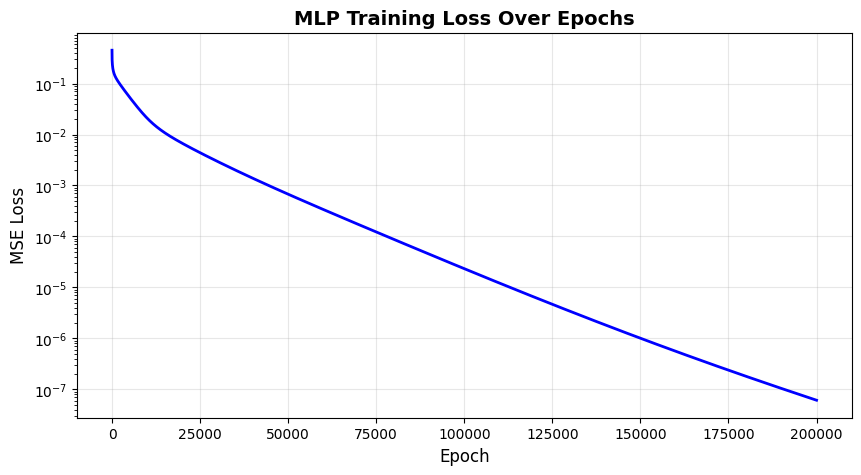

Initial Loss: 0.451361
Final Loss: 0.0000000611
Loss Reduction: 99.999986472805%


In [387]:
# Plot 1: Training Loss Curve
plt.figure(figsize=(10, 5))
plt.plot(model.losses, linewidth=2, color='blue')
plt.title('MLP Training Loss Over Epochs', fontsize=14, fontweight='bold')
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('MSE Loss', fontsize=12)
plt.grid(True, alpha=0.3)
plt.yscale('log')  # Log scale to better see convergence
plt.show()

print(f"Initial Loss: {model.losses[0]:.6f}")
print(f"Final Loss: {model.losses[-1]:.10f}")
print(f"Loss Reduction: {((model.losses[0] - model.losses[-1]) / model.losses[0] * 100):.12f}%")

In [381]:
# Make forecasts where each prediction feeds into the next prediction.
def forecast_multiple_steps(model, last_sequence, n_steps=12):
  
    predictions = []
    current_sequence = last_sequence.copy()
    
    for _ in range(n_steps):
        # Predict next value
        next_value = model.predict(current_sequence.reshape(1, -1))[0]
        predictions.append(next_value)
        
        # Removes oldest component and appends the predicted value
        current_sequence = np.roll(current_sequence, -1)
        current_sequence[-1] = next_value
    
    return np.array(predictions)

# Get last 12 values from training data to start forecasting
last_sequence = training_data[-12:]
print(f"Last training sequence shape: {last_sequence.shape}")

# Forecast next 12 months
validation_predictions_scaled = forecast_multiple_steps(model, last_sequence, n_steps=12)



Last training sequence shape: (12,)


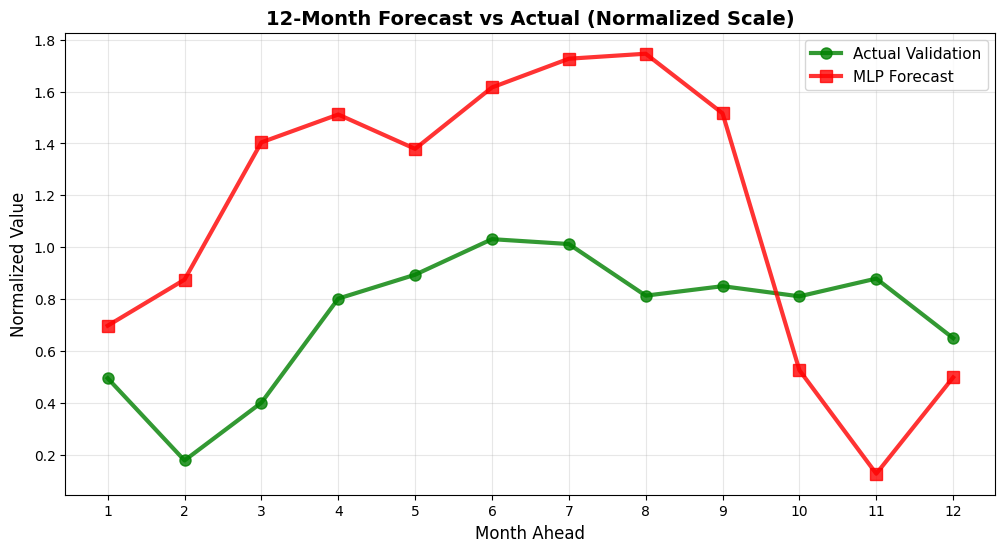


Validation Metrics (Normalized Scale):
MSE: 0.426377
MAE: 0.599149
RMSE: 0.652975


In [382]:
# Plot 3: Validation Predictions vs Actual (Processed Scale)
plt.figure(figsize=(12, 6))
months = np.arange(1, 13)
plt.plot(months, validation_data, 'o-', label='Actual Validation', 
         linewidth=3, markersize=8, color='green', alpha=0.8)
plt.plot(months, validation_predictions_scaled, 's-', label='MLP Forecast', 
         linewidth=3, markersize=8, color='red', alpha=0.8)
plt.title('12-Month Forecast vs Actual (Normalized Scale)', fontsize=14, fontweight='bold')
plt.xlabel('Month Ahead', fontsize=12)
plt.ylabel('Normalized Value', fontsize=12)
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.xticks(months)
plt.show()

# Validation metrics
val_mse = np.mean((validation_predictions_scaled - validation_data) ** 2)
val_mae = np.mean(np.abs(validation_predictions_scaled - validation_data))
val_rmse = np.sqrt(val_mse)
print(f"\nValidation Metrics (Normalized Scale):")
print(f"MSE: {val_mse:.6f}")
print(f"MAE: {val_mae:.6f}")
print(f"RMSE: {val_rmse:.6f}")

In [383]:
# Reverse transformations: Convert predictions back to original scale
print("="*60)
print("REVERSING TRANSFORMATIONS")
print("="*60)

# Step 1: Denormalize predictions
validation_predictions_denorm = scaler.inverse_transform(
    validation_predictions_scaled.reshape(-1, 1)
).flatten()

validation_actual_denorm = scaler.inverse_transform(
    validation_data.reshape(-1, 1)
).flatten()

print("\nStep 1 - Denormalized:")
print(f"Predictions: {validation_predictions_denorm[:3]}...")
print(f"Actual: {validation_actual_denorm[:3]}...")

# Step 2: Reverse seasonal differencing
# We need the detrended values from 12 months before the validation period
reference_values = de_trended[-(24):-12]

# Add back the seasonal component
validation_predictions_deseasoned = validation_predictions_denorm + reference_values
validation_actual_deseasoned = validation_actual_denorm + reference_values

print("\nStep 2 - Reverse seasonal differencing:")
print(f"Predictions: {validation_predictions_deseasoned[:3]}...")
print(f"Actual: {validation_actual_deseasoned[:3]}...")

# Step 3: Add back polynomial trend
# Get trend values for the validation period (last 12 points)
validation_trend = poly_trend[-12:]

validation_predictions_original = validation_predictions_deseasoned + validation_trend
validation_actual_original = validation_actual_deseasoned + validation_trend

print("\nStep 3 - Add back trend:")
print(f"Predictions: {validation_predictions_original[:3]}...")
print(f"Actual: {validation_actual_original[:3]}...")
print(f"\nOriginal validation values from series:")
print(f"Series: {y[-12:][:3]}...")
print("="*60)

REVERSING TRANSFORMATIONS

Step 1 - Denormalized:
Predictions: [304.46554953 386.66973137 631.69344724]...
Actual: [210.68400419  63.97354677 167.06308936]...

Step 2 - Reverse seasonal differencing:
Predictions: [208.50592633 285.4969015  418.02320592]...
Actual: [114.72438099 -37.19928309 -46.60715197]...

Step 3 - Add back trend:
Predictions: [3913.78154534 3922.7961846  3986.73035789]...
Actual: [3820.  3600.1 3522.1]...

Original validation values from series:
Series: [3820.  3600.1 3522.1]...


In [384]:
# Calculate metrics on original scale
original_mse = np.mean((validation_predictions_original - y[-12:]) ** 2)
original_mae = np.mean(np.abs(validation_predictions_original - y[-12:]))
original_rmse = np.sqrt(original_mse)
original_mape = np.mean(np.abs((y[-12:] - validation_predictions_original) / y[-12:])) * 100

print("="*60)
print("FINAL METRICS ON ORIGINAL SCALE")
print("="*60)
print(f"MSE:  {original_mse:.2f}")
print(f"MAE:  {original_mae:.2f}")
print(f"RMSE: {original_rmse:.2f}")
print(f"MAPE: {original_mape:.2f}%")
print("="*60)

# Month-by-month comparison
comparison_df = pd.DataFrame({
    'Month': range(1, 13),
    'Actual': y[-12:],
    'Predicted': validation_predictions_original,
    'Error': validation_predictions_original - y[-12:],
    'Abs_Error': np.abs(validation_predictions_original - y[-12:]),
    'Pct_Error': ((validation_predictions_original - y[-12:]) / y[-12:]) * 100
})

print("\nMonth-by-Month Comparison:")
print(comparison_df.to_string(index=False))

FINAL METRICS ON ORIGINAL SCALE
MSE:  91260.58
MAE:  277.19
RMSE: 302.09
MAPE: 8.09%

Month-by-Month Comparison:
 Month  Actual   Predicted       Error  Abs_Error  Pct_Error
     1  3820.0 3913.781545   93.781545  93.781545   2.455014
     2  3600.1 3922.796185  322.696185 322.696185   8.963534
     3  3522.1 3986.730358  464.630358 464.630358  13.191856
     4  3493.9 3822.475679  328.575679 328.575679   9.404267
     5  3531.7 3756.333522  224.633522 224.633522   6.360493
     6  3492.7 3763.460422  270.760422 270.760422   7.752181
     7  3414.9 3745.649534  330.749534 330.749534   9.685482
     8  3312.0 3743.759593  431.759593 431.759593  13.036220
     9  3257.2 3565.713728  308.513728 308.513728   9.471747
    10  3304.1 3172.287892 -131.812108 131.812108  -3.989350
    11  3306.9 2958.612805 -348.287195 348.287195 -10.532136
    12  3199.7 3129.602198  -70.097802  70.097802  -2.190762


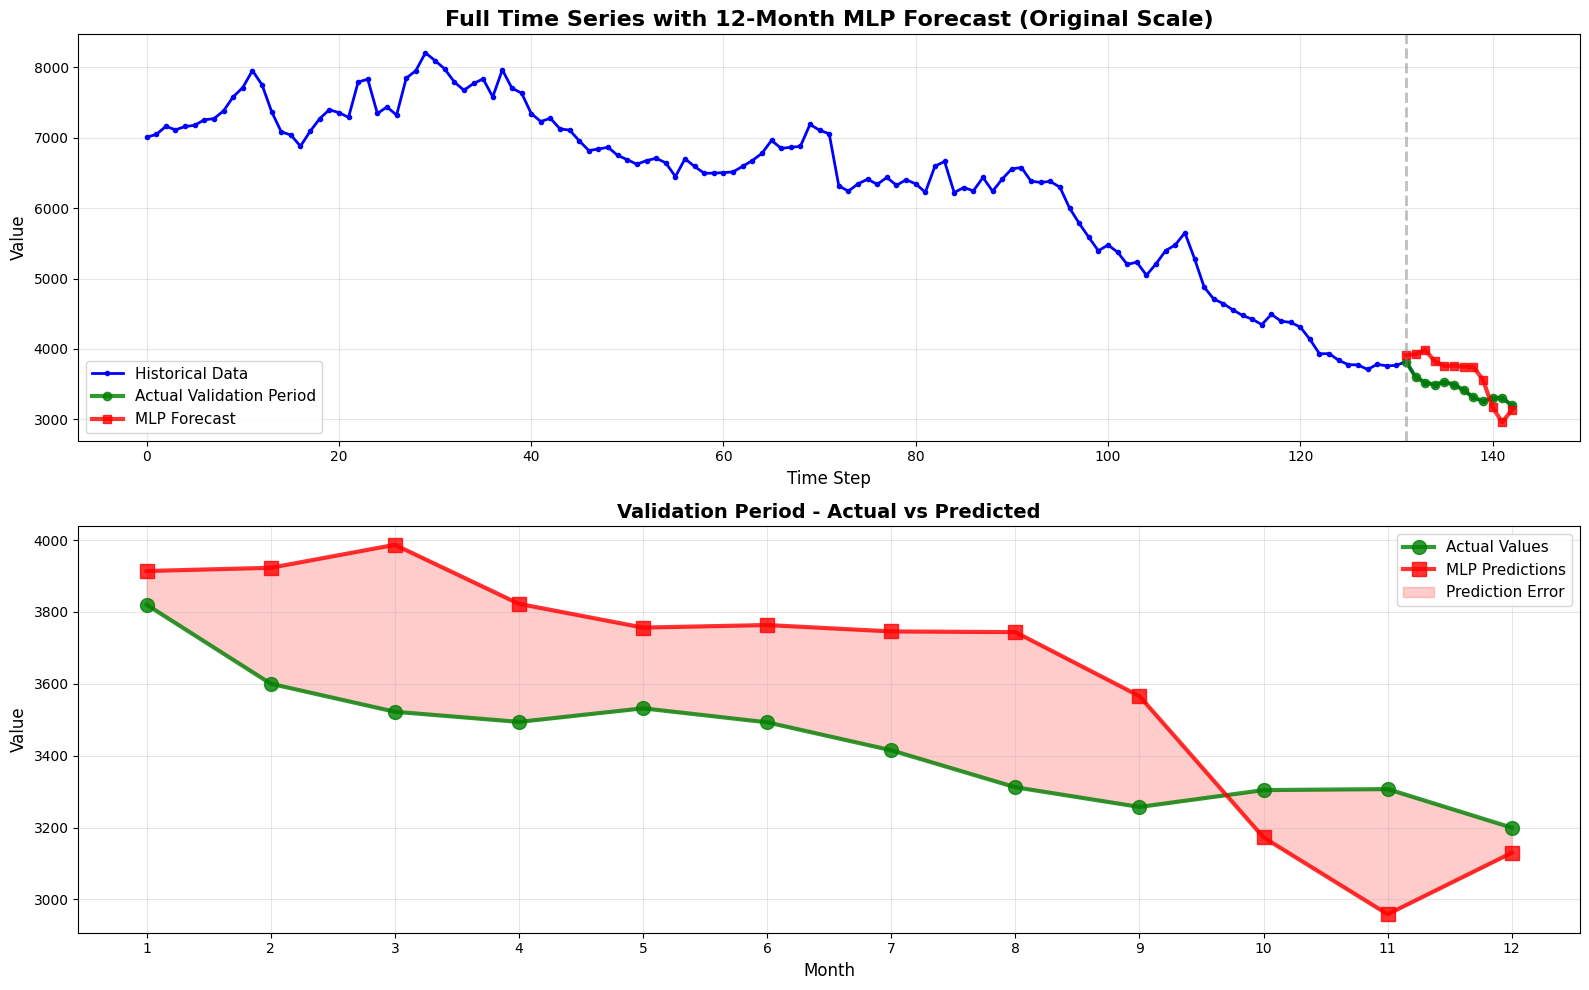

In [385]:
# Plot 4: Full Time Series with Forecast (Original Scale)
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(16, 10))

# Top plot: Full series
ax1.plot(range(len(y)), y, 'b-', linewidth=2, label='Historical Data', marker='o', markersize=3)
ax1.plot(range(len(y) - 12, len(y)), y[-12:], 'go-', linewidth=3, 
         markersize=6, label='Actual Validation Period', alpha=0.8)
ax1.plot(range(len(y) - 12, len(y)), validation_predictions_original, 'rs-', 
         linewidth=3, markersize=6, label='MLP Forecast', alpha=0.8)
ax1.axvline(len(y) - 12, color='gray', linestyle='--', linewidth=2, alpha=0.5)
ax1.set_title('Full Time Series with 12-Month MLP Forecast (Original Scale)', 
              fontsize=16, fontweight='bold')
ax1.set_xlabel('Time Step', fontsize=12)
ax1.set_ylabel('Value', fontsize=12)
ax1.legend(fontsize=11)
ax1.grid(True, alpha=0.3)

# Bottom plot: Zoomed validation period
months = np.arange(1, 13)
ax2.plot(months, y[-12:], 'go-', linewidth=3, markersize=10, 
         label='Actual Values', alpha=0.8)
ax2.plot(months, validation_predictions_original, 'rs-', linewidth=3, 
         markersize=10, label='MLP Predictions', alpha=0.8)
ax2.fill_between(months, y[-12:], validation_predictions_original, 
                  alpha=0.2, color='red', label='Prediction Error')
ax2.set_title('Validation Period - Actual vs Predicted', fontsize=14, fontweight='bold')
ax2.set_xlabel('Month', fontsize=12)
ax2.set_ylabel('Value', fontsize=12)
ax2.legend(fontsize=11)
ax2.grid(True, alpha=0.3)
ax2.set_xticks(months)

plt.tight_layout()
plt.show()